## Импортируем необходимые бибилиотеки

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

## Создадим подключение к базе данных

In [2]:
conn = sqlite3.connect("../data/checking-logs.sqlite")

## Сделаем запрос к базе данных

In [3]:
query = """
SELECT strftime('%d', timestamp) AS day,
    CAST(strftime('%H', timestamp) AS integer) AS hour,
    CAST(strftime('%w', timestamp) AS integer) AS weekday
FROM checker
WHERE checker.uid LIKE 'user_%';
"""
df = pd.read_sql_query(query, conn)
df


,day,hour,weekday
0,17,5,5
1,17,5,5
2,17,5,5
3,17,5,5
4,17,5,5
...,...,...,...
3202,21,20,4
3203,21,20,4
3204,21,20,4
3205,21,20,4


## Определим какой это день: рабочий день или выходной

In [4]:
working_days = df[(df["weekday"] > 0) & (df["weekday"] < 6)]['hour'].tolist()
weekends = df[(df["weekday"] == 0) | (df["weekday"] == 6)]['hour'].tolist()
print(len(working_days), len(weekends))


2037 1170


## Построим график

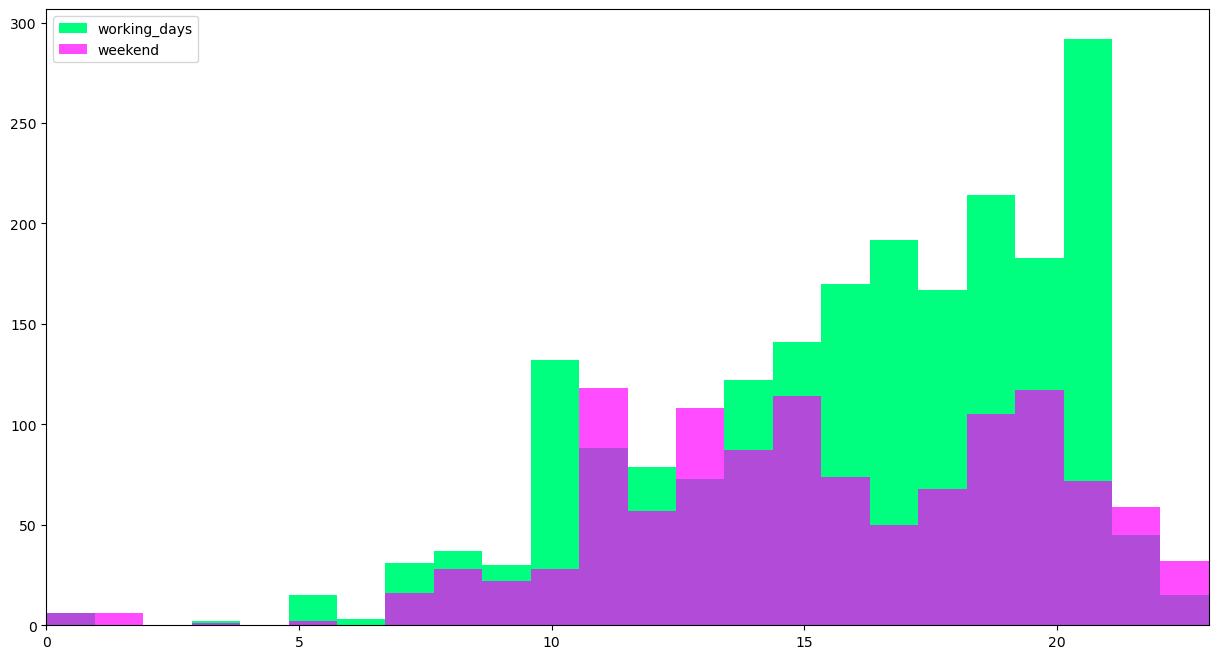

In [5]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(working_days,
        bins=24,
        label='working_days',
        color='springgreen')
ax.hist(weekends,
        bins=24,
        label='weekend',
        alpha=0.7, # Прозрачность 
        color='magenta')
ax.set_xlim(0, 23)
ax.legend(loc='upper left', fontsize='10')
plt.show()

## Есть ли время, когда общее количество коммитов было больше в выходные дни, чем в рабочие? Топ 4 часа

In [6]:
df["type"] = df["weekday"].apply(lambda x: 'working_day' if (x > 0) & (x < 6) else 'weekday') # Определим тип дня недели в датафрейме
grouped_df = df.groupby([ "type", "hour"]).count()
grouped_df = grouped_df.drop(columns='day') # Удалим ненужные столбцы
res_df = grouped_df.pivot_table(index='hour', columns='type', values='weekday') #Перевернем наш датафрейм в более удобный вид

res_df['difference'] = res_df['weekday'] - res_df['working_day'] # Вычислим различие коммитов в выодные и будние дни
res_df = res_df.sort_values(by='difference', ascending=False) # Сортируем датафрейм по убываю разницы коммитов

res_df.head(4)

type,weekday,working_day,difference
hour,,,
13,108.0,73.0,35.0
11,118.0,88.0,30.0
23,32.0,15.0,17.0
22,59.0,45.0,14.0


## Подведём итоги
Общее количество коммитов в выходные больше, чем в рабочие дни **поздним утром/ранним обедом** и **поздним вечером**

## Закроем подключение к базе данных

In [7]:
conn.close()